<a href="https://www.kaggle.com/code/yoshisam/titanic-ml-eval?scriptVersionId=100780330" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Pre-Processing

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

train_fname = '/kaggle/input/titanic/train.csv'
test_fname = '/kaggle/input/titanic/test.csv'

df = pd.read_csv(train_fname)
df = df.fillna(0)
df = df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]
survived = df['Survived']
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
scaled_features = StandardScaler().fit_transform(df[df.columns[:-1]])
df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns[:-1])
df['Survived'] = survived
df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,-1.730108,0.827377,0.737695,-0.102313,0.432793,-0.473674,-0.502445,0
1,-1.726220,-1.566107,-1.355574,0.807492,0.432793,-0.473674,0.786845,1
2,-1.722332,0.827377,-1.355574,0.125138,-0.474545,-0.473674,-0.488854,1
3,-1.718444,-1.566107,-1.355574,0.636903,0.432793,-0.473674,0.420730,1
4,-1.714556,0.827377,0.737695,0.636903,-0.474545,-0.473674,-0.486337,0


## Correlations & Feature Extraction

In [3]:
corr = abs(df.corr()['Survived'].drop('Survived')).sort_values(ascending=False)
features = list(corr[:-1].keys())
print(corr)
print(features)

Sex            0.543351
Pclass         0.338481
Fare           0.257307
Parch          0.081629
SibSp          0.035322
Age            0.010539
PassengerId    0.005007
Name: Survived, dtype: float64
['Sex', 'Pclass', 'Fare', 'Parch', 'SibSp', 'Age']


## SKLearn Models

In [4]:
from sklearn.model_selection import train_test_split

X = np.array(df[features])
y = np.array(df['Survived'])

In [5]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


lr = MLPClassifier()

print('Training Model')

lr.fit(X, y)

#print('Making Predictions')

#preds = lr.predict(X_test)

#print('Scoring Predictions')

#lr.score(X_test, y_test)

Training Model


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier()

In [6]:
#from sklearn.metrics import f1_score

#f1_score(y_test, preds)

## PyTorch Models

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [8]:
class TitanicDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        
        x = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        
        self.transform = transform
        self.target_transform = target_transform
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.float32)
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        data = self.x[idx]
        label = self.y[idx]
        
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return self.x[idx], self.y[idx]

In [9]:
torch_features = features[:]
torch_features.append('Survived')
train_data = TitanicDataset(df[torch_features].sample(frac=0.9))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 6])
Labels batch shape: torch.Size([32])


In [11]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(6, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            )

    def forward(self, x):
        x = self.layers(x)
        x = F.sigmoid(x)
        return x

In [12]:
model = MLP()
print(model)

# Define the loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [13]:
def accuracy(outputs, targets):
    num_correct = 0
    num_samples = 0
    num_correct += (outputs == targets).sum()
    num_samples += outputs.size(0)
    return num_correct / num_samples

In [14]:
epochs = 300

metrics = {}
metrics['loss'] = []
metrics['accuracy'] = []

print('Beginning Training')
for epoch in range(epochs): # iterate through each epoch
    epoch_loss = 0
    epoch_accuracy = 0
    for idx, batch in enumerate(train_loader):
        inputs, labels = batch
        labels = torch.unsqueeze(labels, 1)
        
        
        optimizer.zero_grad() # zero the gradients each batch
        
        outputs = model(inputs)# return class probabilities?
        
        predictions = (outputs > 0.5).float()
        
        loss = loss_fn(outputs, labels) # calculate loss
        
        loss.backward() # backpropagation?
        
        optimizer.step() # update learning weights
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy(predictions, labels)
    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1} -> Loss: {epoch_loss / (idx + 1)} Accuracy: {epoch_accuracy / (idx + 1)}')
    metrics['accuracy'].append(epoch_accuracy / (idx + 1))
    metrics['loss'].append(epoch_loss / (idx + 1))

Beginning Training
Epoch 1 -> Loss: 0.5479861165468509 Accuracy: 0.7211538553237915


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 11 -> Loss: 0.395735033429586 Accuracy: 0.8377403616905212
Epoch 21 -> Loss: 0.3620369623486812 Accuracy: 0.8521634340286255
Epoch 31 -> Loss: 0.38034310191869736 Accuracy: 0.8317307829856873
Epoch 41 -> Loss: 0.3380200112095246 Accuracy: 0.8605769276618958
Epoch 51 -> Loss: 0.35696813062979627 Accuracy: 0.8557692170143127
Epoch 61 -> Loss: 0.35323582503658074 Accuracy: 0.8653846383094788
Epoch 71 -> Loss: 0.30731167128452885 Accuracy: 0.8725961446762085
Epoch 81 -> Loss: 0.3331217857507559 Accuracy: 0.8557692170143127
Epoch 91 -> Loss: 0.32011778022234255 Accuracy: 0.8737980723381042
Epoch 101 -> Loss: 0.3058568795139973 Accuracy: 0.8737980723381042
Epoch 111 -> Loss: 0.28464811821826375 Accuracy: 0.885817289352417
Epoch 121 -> Loss: 0.3302253180971512 Accuracy: 0.8581730723381042
Epoch 131 -> Loss: 0.2904510511227552 Accuracy: 0.879807710647583
Epoch 141 -> Loss: 0.2907777719486218 Accuracy: 0.8834134340286255
Epoch 151 -> Loss: 0.28388583516845334 Accuracy: 0.8810096383094788


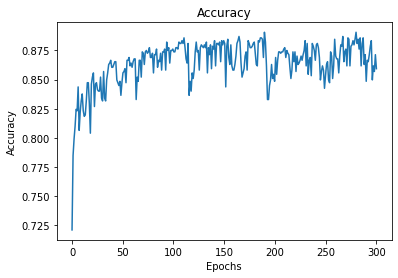

Text(0, 0.5, 'Accuracy')

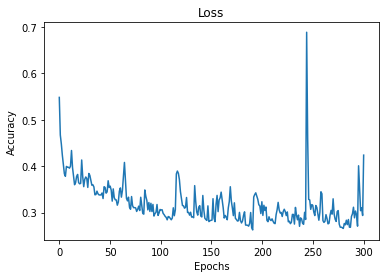

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(np.linspace(0, epochs, epochs), metrics['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(np.linspace(0, epochs, epochs), metrics['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [16]:
df_test = pd.read_csv(test_fname)
df_test = df_test.fillna(0)
df_test = df_test[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
df_test['Sex'] = LabelEncoder().fit_transform(df_test['Sex'])
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,1,34.5,0,0,7.8292
1,893,3,0,47.0,1,0,7.0000
2,894,2,1,62.0,0,0,9.6875
3,895,3,1,27.0,0,0,8.6625
4,896,3,0,22.0,1,1,12.2875


In [17]:
X = np.array(df_test[features], dtype=np.float32)

inputs = torch.tensor(X)

outputs = model(inputs)# return class probabilities?
        
predictions = (outputs > 0.5).int()

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
submission = {'PassengerId':df_test['PassengerId'], 'Survived':predictions.reshape((418,))}
submission = pd.DataFrame(submission)
submission = submission.to_csv('submission.csv', index=False)
#submission.head()